In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm  #

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
# Defina as transformações para redimensionar e normalizar as imagens
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
# Carregue o conjunto de dados CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Defina o dataloader
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)


In [6]:

# Defina a arquitetura da AlexNet simplificada
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


In [7]:

# Instancie a AlexNet
alexnet = AlexNet().to(device)


In [8]:
# Defina a função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.01, momentum=0.9)
# Treine a rede
num_epochs = 10
train_losses = []
test_losses = []

In [9]:

for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    tqdm_trainloader = tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}, Training', dynamic_ncols=True)

    for i, data in enumerate(tqdm_trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Mova os dados para o dispositivo correto

        optimizer.zero_grad()

        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        tqdm_trainloader.set_postfix({'loss': running_loss / (i + 1)})

    # Calcule a perda média no conjunto de treinamento
    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # Avalie o modelo no conjunto de teste
    alexnet.eval()
    running_test_loss = 0.0
    tqdm_testloader = tqdm(testloader, desc=f'Epoch {epoch+1}/{num_epochs}, Testing', dynamic_ncols=True)

    with torch.no_grad():
        for data in tqdm_testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Mova os dados para o dispositivo correto

            outputs = alexnet(inputs)
            test_loss = criterion(outputs, labels)
            running_test_loss += test_loss.item()

    # Calcule a perda média no conjunto de teste
    test_loss = running_test_loss / len(testloader)
    test_losses.append(test_loss)

    tqdm_trainloader.set_postfix({'Training Loss': train_loss, 'Testing Loss': test_loss})
    tqdm_trainloader.close()
    tqdm_testloader.close()

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch 1/10, Training:  18%|█▊        | 274/1563 [00:20<01:37, 13.17it/s, loss=2.24]


KeyboardInterrupt: 

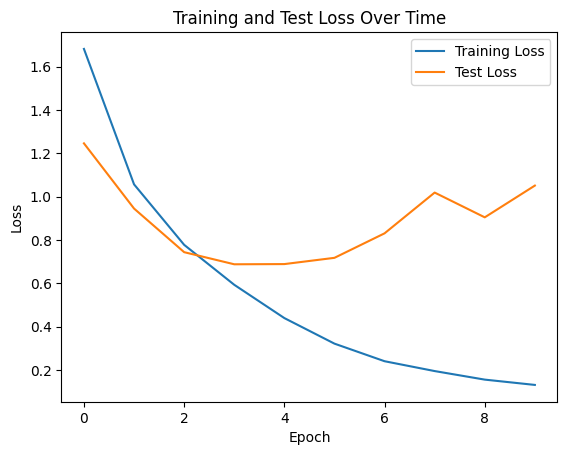

In [ ]:
# Plote gráficos de perda
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Time')
plt.show()


In [ ]:

# Avalie o modelo usando a matriz de confusão
def plot_confusion_matrix(model, dataloader, classes):
    model.eval()
    model = model.to(device)  # Mova o modelo para o dispositivo correto
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        tqdm_dataloader = tqdm(dataloader, desc='Generating Confusion Matrix', dynamic_ncols=True)
        for inputs, labels in tqdm_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Mova os dados para o dispositivo correto
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    tqdm_dataloader.close()

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(len(classes), len(classes)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


In [ ]:
# Lista de classes no CIFAR-10
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog']


Generating Confusion Matrix: 100%|██████████| 1563/1563 [00:52<00:00, 29.85it/s]


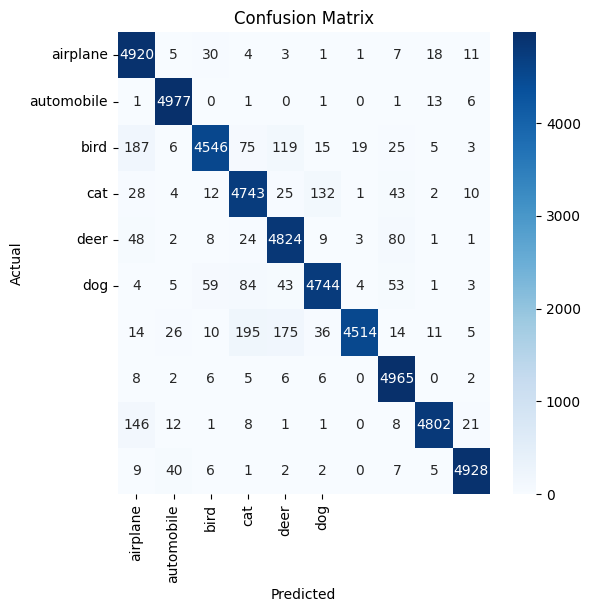

In [ ]:
plot_confusion_matrix(alexnet, trainloader, cifar10_classes)

Generating Confusion Matrix: 100%|██████████| 313/313 [00:11<00:00, 28.25it/s]


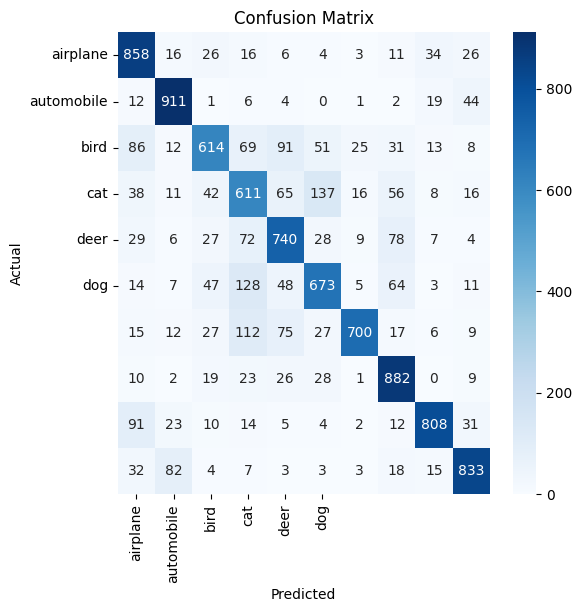

In [ ]:
plot_confusion_matrix(alexnet, testloader, cifar10_classes)